In [ ]:
!pip install nilearn

In [1]:
import os
import numpy as np
import math
from nibabel.testing import data_path
import nibabel as nib
from nilearn import image

import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

import scipy.io
import cv2

# Preprocessing

In [2]:
filename = './data/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii'

In [3]:
maskname = './data/sub-01/ses-test/func/c6sub-01_ses-test_task-fingerfootlips_bold.nii'

In [4]:
def preprocessing(filename, maskname):
    # return processed images with mask
    
    # loading image
    img = nib.load(filename)
    img_mask = nib.load(maskname)
    
    # open up file components
    test_img=[]
    for volume in image.iter_img(filename):
        test_img.append(volume.dataobj)
        
    test_img = np.array(test_img)
    test_mask = img_mask.get_fdata()
    
    # binary mask with threshold
    th, dst = cv2.threshold(img_mask.get_fdata(),0.8,1, cv2.THRESH_BINARY_INV)
    
    # for each image in 184, match with corresponding mask. since mask is 0 and 1, just need to multiple all of them
    clean_test_img = test_img.copy()
    for i in range(len(test_img)):
        for j in range(dst.shape[2]):
            t_img = test_img[i,:,:,j]
            m_img = dst[:,:,j]
            new = t_img * m_img
            clean_test_img[i,:,:,j] = new
    clean_test_img = np.array(clean_test_img)
    return clean_test_img

In [5]:
cleaned_imgs = preprocessing(filename, maskname)

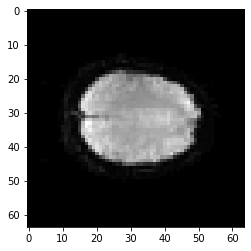

In [6]:
plt.imshow(cleaned_imgs[1,:,:,20],cmap='gray')

In [7]:
mat = scipy.io.loadmat('./data/label.mat')

In [8]:
label = mat['label']

# label 1 means Rest (fixation) which has 94 volumes
# label 2 means Finger movement which has 30 volumes
# label 3 means Lips movement which has 30 volumes
# label 4 means Foot movement which has 30 volumes

In [9]:
len(label)

184

# Feature Selection


In [10]:
def feature_selection(cleaned_images, n):
    # PCA
    
    # first decompose to matrix of 184 and combination of all other levels
    size, s1, s2, s3 = cleaned_images.shape
    reshaped_images = cleaned_images.reshape(size, s1*s2*s3)
    
    pca = PCA(n_components=n)
    pca_images = pca.fit_transform(reshaped_images)
    
    return reshaped_images, pca_images

In [11]:
reshaped_imgs, pca_imgs = feature_selection(cleaned_imgs, 80)

In [12]:
pca_imgs.shape

(184, 80)

# Classification & K-fold Cross Validation

In [13]:
labels = label.flatten()
labels

array([1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3,
       1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 4, 4,
       4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1,
       1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4,
       4, 4, 1, 1, 1, 1, 1, 1], dtype=uint8)

In [25]:
param_grid = {'C':[0.0001, 0.001, 0.01, 0.1,1,10],
          'gamma':[0.00001, 0.0001,0.001,0.1,1],
          'kernel':['linear','rbf','poly']}

cross_val = StratifiedKFold(n_splits=9)

svc = svm.SVC()
clf = GridSearchCV(svc, param_grid, cv=cross_val)
clf.fit(pca_imgs, labels)

print('tuned hyperparameters for PCA')
print('Best parameters: {}'.format(clf.best_params_))

tuned hyperparameters for PCA
Best parameters: {'C': 0.0001, 'gamma': 1e-05, 'kernel': 'linear'}


# Test Images

In [26]:
svc_test = svm.SVC(kernel=clf.best_params_['kernel'], C=clf.best_params_['C'], gamma=clf.best_params_['gamma'])
# PCA
np.mean(cross_val_score(svc_test,pca_imgs,labels,cv=31))

/Users/mirandazhou/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 30 members, which is less than n_splits=31.
  warnings.warn(("The least populated class in y has only %d"


0.8860215053763442

In [27]:
# no PCA
np.mean(cross_val_score(svc_test,reshaped_imgs,labels,cv=31))


/Users/mirandazhou/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 30 members, which is less than n_splits=31.
  warnings.warn(("The least populated class in y has only %d"


0.875268817204301